# NBA Home Win Prediction (Random Forest)

This notebook predicts whether the **home team wins** (`WIN = 1`) or loses (`WIN = 0`) using a **Random Forest classifier**.

**What’s here:**
- Reproducible configuration (seed, split strategy)
- Input validation & schema checks
- Train/eval via a `Pipeline` (imputation + model)
- Stronger evaluation (accuracy, ROC AUC, precision/recall, confusion matrix, ROC curve)
- Model explainability basics (feature importance)


In [ ]:
from __future__ import annotations

from pathlib import Path
import json
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    roc_auc_score,
    precision_recall_fscore_support,
    ConfusionMatrixDisplay,
    RocCurveDisplay,
)

import matplotlib.pyplot as plt

RANDOM_STATE = 42
TEST_SIZE = 0.20


DATA_PATH = Path("/data/nba-points-prediction.csv")
RESULTS_DIR = Path("results")
RESULTS_DIR.mkdir(exist_ok=True)

if not DATA_PATH.exists():
    alt = Path("data") / "nba-points-prediction.csv"
    if alt.exists():
        DATA_PATH = alt

print(f"Using dataset: {DATA_PATH.resolve()}")


Using dataset: C:\Users\Owner\Desktop\GitHub Projects\ML and DS Highlights\machine-learning-lab\notebooks\jupyter\nba-points-prediction\data\nba-points-prediction.csv


In [2]:
# Load dataset + quick sanity checks
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
display(df.head(5))

# Minimal required columns for this modeling approach
REQUIRED_COLS = [
    "PTS_HOME", "PTS_AWAY",
    "FG_PCT_HOME", "FG_PCT_AWAY",
    "REB_HOME", "REB_AWAY",
    "AST_HOME", "AST_AWAY",
]

missing = [c for c in REQUIRED_COLS if c not in df.columns]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

# Drop rows with missing values in any required column (simple baseline strategy)
before = len(df)
df = df.dropna(subset=REQUIRED_COLS).copy()
after = len(df)
print(f"Dropped {before-after} rows with missing values in required columns.")


Shape: (1000, 9)


,FG_PCT_HOME,FG_PCT_AWAY,REB_HOME,REB_AWAY,AST_HOME,AST_AWAY,PTS_HOME,PTS_AWAY,WIN
0,0.444,0.396,57,37,29,21,100,119,0
1,0.588,0.485,36,55,20,16,132,127,1
2,0.533,0.568,32,46,34,25,101,130,0
3,0.500,0.533,52,37,23,27,114,122,0
4,0.389,0.552,57,36,34,19,116,113,1


Dropped 0 rows with missing values in required columns.


In [3]:
# Target engineering (fixed vs original notebook)
# WIN = 1 if home team points > away team points; else 0
df["WIN"] = (df["PTS_HOME"] > df["PTS_AWAY"]).astype(int)

# Feature selection (all are known post-game in many datasets, but used here as provided)
FEATURES = ["FG_PCT_HOME", "FG_PCT_AWAY", "REB_HOME", "REB_AWAY", "AST_HOME", "AST_AWAY"]

X = df[FEATURES].copy()
y = df["WIN"].copy()

print("Home-win rate:", float(y.mean()))
display(X.describe(include="all"))


Home-win rate: 0.485


,FG_PCT_HOME,FG_PCT_AWAY,REB_HOME,REB_AWAY,AST_HOME,AST_AWAY
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.472567,0.476745,44.624000,44.558000,24.869000,24.917000
std,0.073041,0.073058,8.667165,8.660464,5.686667,5.687923
min,0.351000,0.351000,30.000000,30.000000,15.000000,15.000000
25%,0.408750,0.410000,37.000000,37.000000,20.000000,20.000000
50%,0.474000,0.480000,45.000000,45.000000,25.000000,25.000000
75%,0.536000,0.540000,52.000000,52.000000,30.000000,30.000000
max,0.600000,0.600000,59.000000,59.000000,34.000000,34.000000


In [4]:
# Split (reproducible + stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)


Train size: (800, 6) Test size: (200, 6)


In [5]:
# Train (Pipeline: impute -> RandomForest)
# Why a Pipeline:
# - avoids training-serving skew (same preprocessing in training & inference)
# - easier to productionize later

model = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("rf", RandomForestClassifier(
        n_estimators=500,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight="balanced",
        min_samples_split=4,
        min_samples_leaf=2,
    )),
])

model.fit(X_train, y_train)
print("Model trained.")


Model trained.


{
  "accuracy": 0.505,
  "roc_auc": 0.5055549994995496,
  "precision": 0.4888888888888889,
  "recall": 0.4536082474226804,
  "f1": 0.47058823529411764,
  "test_rows": 200,
  "random_state": 42,
  "features": [
    "FG_PCT_HOME",
    "FG_PCT_AWAY",
    "REB_HOME",
    "REB_AWAY",
    "AST_HOME",
    "AST_AWAY"
  ]
}


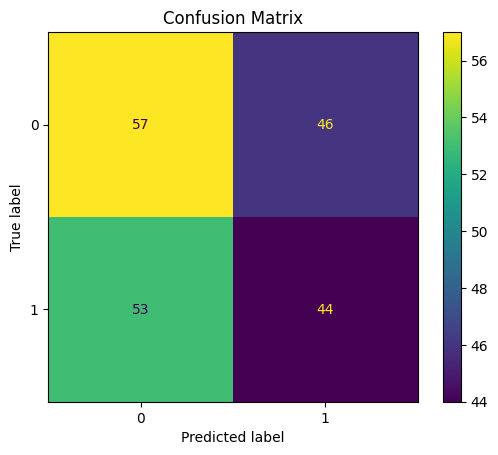

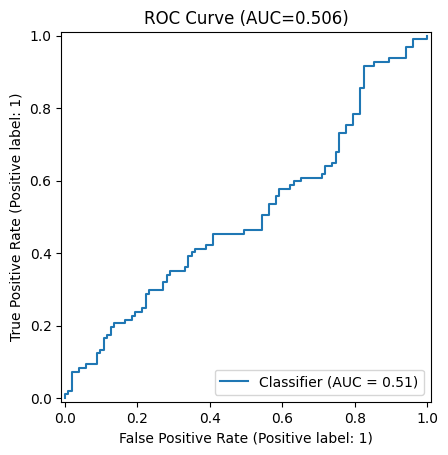

In [6]:
# Evaluate (metrics + visuals)
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

acc = float(accuracy_score(y_test, y_pred))
auc = float(roc_auc_score(y_test, y_prob))

precision, recall, f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="binary", zero_division=0
)

metrics = {
    "accuracy": acc,
    "roc_auc": auc,
    "precision": float(precision),
    "recall": float(recall),
    "f1": float(f1),
    "test_rows": int(len(y_test)),
    "random_state": RANDOM_STATE,
    "features": FEATURES,
}

print(json.dumps(metrics, indent=2))

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Confusion Matrix")
plt.show()

# ROC curve
RocCurveDisplay.from_predictions(y_test, y_prob)
plt.title(f"ROC Curve (AUC={auc:.3f})")
plt.show()


,feature,importance
0,FG_PCT_HOME,0.204037
1,FG_PCT_AWAY,0.200321
2,REB_HOME,0.158137
3,REB_AWAY,0.152229
4,AST_HOME,0.148206
5,AST_AWAY,0.137070


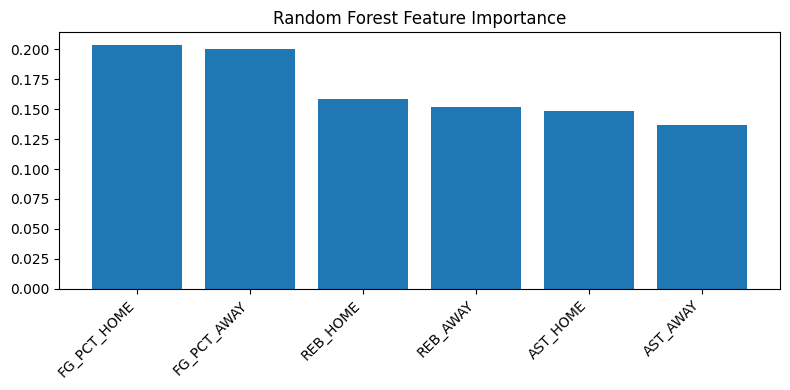

In [7]:
# Feature importance (quick explainability)
rf = model.named_steps["rf"]
importances = rf.feature_importances_
fi = pd.DataFrame({"feature": FEATURES, "importance": importances}).sort_values("importance", ascending=False)
display(fi)

plt.figure(figsize=(8, 4))
plt.bar(fi["feature"], fi["importance"])
plt.xticks(rotation=45, ha="right")
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()


In [ ]:
out_metrics = RESULTS_DIR / "metrics.json"
out_metrics.write_text(json.dumps(metrics, indent=2), encoding="utf-8")
print(f"Wrote: {out_metrics.resolve()}")


FileNotFoundError: [Errno 2] No such file or directory: '\\results\\metrics.json'

In [ ]:
# Example inference (single game)
new_game = pd.DataFrame([{
    "FG_PCT_HOME": 0.48,
    "FG_PCT_AWAY": 0.45,
    "REB_HOME": 52,
    "REB_AWAY": 32,
    "AST_HOME": 32,
    "AST_AWAY": 18,
}])

proba_home_win = float(model.predict_proba(new_game)[:, 1][0])
pred = int(proba_home_win >= 0.5)

print(f"P(home win) = {proba_home_win:.3f}")
print("Predicted: WIN" if pred == 1 else "Predicted: LOSS")
